# Sentiment Analysis on News Headlines

### About Dataset
Context
This dataset (FinancialPhraseBank) contains the sentiments for financial news headlines from the perspective of a retail investor.

Content
The dataset contains two columns, "Sentiment" and "News Headline". The sentiment can be negative, neutral or positive.

Acknowledgements
Malo, P., Sinha, A., Korhonen, P., Wallenius, J., & Takala, P. (2014). Good debt or bad debt: Detecting semantic orientations in economic texts. Journal of the Association for Information Science and Technology, 65(4), 782-796.

source: https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news



### Part1. Import the Dataset  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

#pre-processing texts
import spacy
import regex as re
from sklearn.feature_extraction.text import CountVectorizer
import nltk #stopwords library

# train split-data, CV
from sklearn.model_selection import cross_val_score, train_test_split

# ML model 
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from mlxtend.classifier import StackingClassifier

#Neural network
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers
import keras.optimizers

#evaluation performance 
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix

#deployment woth Gradio
import gradio as gr 



In [2]:
import chardet
with open('all-data.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}

In [88]:
#import dataset
columns = [ "Sentiment", "News Headline"]
data = pd.read_csv('all-data.csv',encoding='ISO-8859-1', header = None, names = columns)
data.head(50).values

array([['neutral',
        'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'],
       ['neutral',
        'Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .'],
       ['negative',
        'The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .'],
       ['positive',
        'With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .'],
       ['positive',
        "According to the company 's updated strategy for the years 2009-2012 , Basware targets a l

sentence   Lithuanian beer market 14.41 liter January rise 0.8 percent year early figure Lithuanian brewers association report cite result member
Outputs shape
sentence   february Finnish medium sanoma oyj hel saa1v yesterday net profit triple eur297 .3 eur107 .1 announce proposal raise payout
Outputs shape


In [4]:
data.shape # check size of dataset

(4846, 2)

In [5]:
data.iloc[3]

Sentiment                                                 positive
News Headline    With the new production plant the company woul...
Name: 3, dtype: object

<AxesSubplot:>

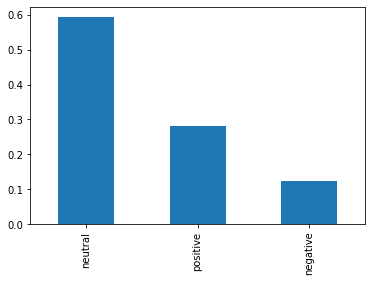

In [6]:
# check percentage of value in target column('Sentiment')
y = data['Sentiment']
y.value_counts(normalize = True).plot(kind='bar')

In [7]:
#check any Null value in both columns
data.isna().sum()

Sentiment        0
News Headline    0
dtype: int64

### Part2. Pre-Processing data 

In [8]:
# mark on index of neutral sentiment
mark = data[data['Sentiment'] == 'neutral']
mark.sample(5)

,Sentiment,News Headline
2669,neutral,The proposal by the Board of Directors on the ...
1011,neutral,`` The summer collection 2008 will be joyfully...
2230,neutral,The Group 's revenue in 2008 amounted to EUR 9...
2974,neutral,"ISMS does not disclose its financial results ,..."
2011,neutral,Export accounts for about one tenth of the com...


In [9]:
# drop 'neutral sentiment' from the dataset
data = data.drop(mark.index, axis = 0)
data.shape

(1967, 2)

In [10]:
# check for values in 'sentiment column'
data['Sentiment'].value_counts()  # 30.7% is Negative news

positive    1363
negative     604
Name: Sentiment, dtype: int64

In [11]:
#convert dataType of target column : positive = 1 , negative = 0
data['Sentiment'] = data['Sentiment'].map(lambda x: 1 if x == 'positive' else 0)

In [12]:
data['Sentiment'].value_counts()  # 30.6% Negative news

1    1363
0     604
Name: Sentiment, dtype: int64

#### Pre-processing:  Cleaning text, remove stopwords, lemmatization

In [13]:
# apply lowercase to texts
data['News Headline']= data['News Headline'].str.lower()

In [14]:
#remove all numeric from texts
data['News Headline'].replace("[^a-zA-Z]"," ",regex=True, inplace=True) #pands formatting

In [15]:
data['News Headline'].iloc[2]

'according to the company  s updated strategy for the years             basware targets a long term net sales growth in the range of            with an operating profit margin of            of net sales  '

In [16]:
# function : clean text, remove punction and apply lemmatization
nlp = spacy.load('en_core_web_sm')

def convert_text(text):
    sent = nlp(text)
    ents = {x.text: x for x in sent.ents}
    tokens = []
    for w in sent:
        if w.is_stop or w.is_punct or w.is_digit:
            continue
        if w.text in ents:
            tokens.append(w.text)
        else:
            tokens.append(w.lemma_.lower())
    text = ' '.join(tokens)

    return text

In [17]:
news_headline = data['News Headline'].apply(convert_text)

In [18]:
# create stopwords list and add a few extra texts
stopWords = nltk.corpus.stopwords.words('english')
stopWords.sort()
stopWords.append('eur')
stopWords.append('mn')
stopWords.append('ac')
stopWords.append('x')
stopWords.append('total')
stopWords.append('million')
stopWords.append('say')
stopWords.append('company')
stopWords.append('st petersburg')
stopWords.append('job')
print(', '.join(stopWords))

a, about, above, after, again, against, ain, all, am, an, and, any, are, aren, aren't, as, at, be, because, been, before, being, below, between, both, but, by, can, couldn, couldn't, d, did, didn, didn't, do, does, doesn, doesn't, doing, don, don't, down, during, each, few, for, from, further, had, hadn, hadn't, has, hasn, hasn't, have, haven, haven't, having, he, her, here, hers, herself, him, himself, his, how, i, if, in, into, is, isn, isn't, it, it's, its, itself, just, ll, m, ma, me, mightn, mightn't, more, most, mustn, mustn't, my, myself, needn, needn't, no, nor, not, now, o, of, off, on, once, only, or, other, our, ours, ourselves, out, over, own, re, s, same, shan, shan't, she, she's, should, should've, shouldn, shouldn't, so, some, such, t, than, that, that'll, the, their, theirs, them, themselves, then, there, these, they, this, those, through, to, too, under, until, up, ve, very, was, wasn, wasn't, we, were, weren, weren't, what, when, where, which, while, who, whom, why, w

In [19]:
# create word/token sentence 
tokens = news_headline  #initial tokens-list same size as news_headline
for i, t in enumerate(data['News Headline']):
    tokens.iloc[i] = nltk.word_tokenize(news_headline.iloc[i])
    
tokens.head()

2    [international, electronic, industry, company,...
3    [new, production, plant, company, increase, ca...
4    [accord, company, s, update, strategy, years, ...
5    [financing, aspocomp, s, growth, aspocomp, agg...
6    [quarter, componenta, s, net, sale, double, eu...
Name: News Headline, dtype: object

In [20]:
# remove stopwords from the tokens-list
tokens_no_stop = tokens # initial list

for i, t in enumerate(tokens):
    tokens_no_stop.iloc[i] = [word for word in tokens.iloc[i] if not word in stopWords]

tokens_no_stop.head()

2    [international, electronic, industry, elcoteq,...
3    [new, production, plant, increase, capacity, m...
4    [accord, update, strategy, years, basware, tar...
5    [financing, aspocomp, growth, aspocomp, aggres...
6    [quarter, componenta, net, sale, double, perio...
Name: News Headline, dtype: object

In [21]:
# join all tokens-word into a sentence
news_headline = tokens_no_stop # initial list
for row,t in enumerate(tokens_no_stop):
    for i in enumerate(tokens_no_stop.iloc[row]):
        result = (' '.join(str(x) for x in tokens_no_stop.iloc[row]))
    news_headline.iloc[row] = result
    
news_headline.head()

2    international electronic industry elcoteq lay ...
3    new production plant increase capacity meet ex...
4    accord update strategy years basware target lo...
5    financing aspocomp growth aspocomp aggressivel...
6    quarter componenta net sale double period year...
Name: News Headline, dtype: object

In [22]:
# sample display a sentence after cleaning texts
news_headline.iloc[10]

'purchase agreement ton gasoline delivery hamina terminal finland sign neste oil oyj average platt index september plus dollar month'

### Part 3. Create a predictor matrix of words from the news with CountVectorizer

In [23]:
cv = CountVectorizer(ngram_range=(1,1), binary=True, stop_words='english', max_features = 6000)
words = cv.fit_transform(news_headline)

In [24]:
words

<1967x3934 sparse matrix of type '<class 'numpy.int64'>'
	with 19848 stored elements in Compressed Sparse Row format>

In [25]:
#size of vector
words.shape

(1967, 3934)

In [26]:
# convert into panda dataframe
words = pd.DataFrame(words.todense(), columns=cv.get_feature_names())
words.head()

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaland,aalborg,ab,abb,ability,able,abn,abp,abroad,acanb,...,yry,yuval,zahariev,zaharova,zero,zgody,zinc,zoltan,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [27]:
# all vocaburaly in dataset (with ngram 1 word)
dictionary = cv.get_feature_names()
dictionary

/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aaland',
 'aalborg',
 'ab',
 'abb',
 'ability',
 'able',
 'abn',
 'abp',
 'abroad',
 'acanb',
 'acando',
 'accelerate',
 'accept',
 'access',
 'accessible',
 'accessory',
 'accommodation',
 'accomplish',
 'accord',
 'accordance',
 'account',
 'accounting',
 'acg',
 'achieve',
 'acid',
 'acknowledge',
 'acnielsen',
 'acquire',
 'acquisition',
 'acquit',
 'acs',
 'act',
 'action',
 'activate',
 'activation',
 'active',
 'actively',
 'activeness',
 'activision',
 'activity',
 'actor',
 'actual',
 'actually',
 'ad',
 'adac',
 'adanac',
 'adaptation',
 'adapter',
 'add',
 'addition',
 'additional',
 'additionally',
 'address',
 'adequate',
 'adjacent',
 'adjust',
 'adjusted',
 'adjustment',
 'administration',
 'administrative',
 'administrator',
 'admire',
 'adopt',
 'adp',
 'adpnews',
 'adr',
 'advance',
 'advanced',
 'advantage',
 'advertiser',
 'advertising',
 'advise',
 'advisor',
 'advisory',
 'aero',
 'afe',
 'affarsvarlden',
 'affect',
 'affecto',
 'affectogenimap',
 'affordable',


#### Apply Kbest Feature Selection

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
print("Feature data dimension: ", words.shape) 
X = words.values
y = data['Sentiment']

Feature data dimension:  (1967, 3934)


In [30]:
select = SelectKBest(score_func=chi2, k=3000)
z = select.fit_transform(X,y)

print("After selecting best 3000 features:", z.shape) 

After selecting best 3000 features: (1967, 3000)


In [31]:
filter = select.get_support()
features = np.array(cv.get_feature_names())
 
# print("All features:")
# print(features)
 
print("Selected best 3000:")
print(features[filter])
print(np.size(features[filter]))
print(z.shape)
z_columns = features[filter]

Selected best 3000:
['aaland' 'ability' 'able' ... 'zinc' 'zoltan' 'zoo']
3000
(1967, 3000)


/Users/mac/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
z

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [33]:
z_words = pd.DataFrame(z, columns=z_columns)
z_words.shape

(1967, 3000)

### Part 4. Split data into training and testing set

In [34]:
# define X and y 
# X = words.values
X = z_words # Kbest featureSelection
y = data['Sentiment']

In [35]:
cv.fit_transform(X,y)

<3000x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 3000 stored elements in Compressed Sparse Row format>

In [36]:
# split data traing and testing set with stratify = True for balancing target values and test size = 10% of all data
X_train, X_test, y_train, y_test = train_test_split(X, data['Sentiment'], test_size=0.10, stratify=data['Sentiment'])

In [37]:
# check size of data
print(X_train.shape, X_test.shape)

(1770, 3000) (197, 3000)


1    137
0     60
Name: Sentiment, dtype: int64


<AxesSubplot:>

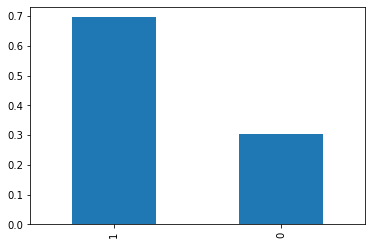

In [38]:
# check values in y_test
print(y_test.value_counts())
y_test.value_counts(normalize = True).plot(kind='bar')

1    1226
0     544
Name: Sentiment, dtype: int64


<AxesSubplot:>

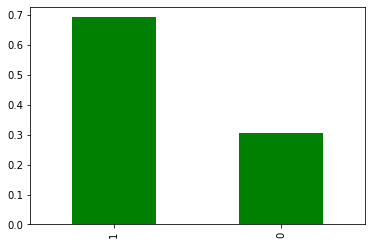

In [39]:
# check values in y_train
print(y_train.value_counts())
y_train.value_counts(normalize = True).plot(kind='bar', color = 'g')

### Part 5. Build a single model < MultinomialNB model >

In [41]:
# because we are using the binary feature here it is best to use
nb = MultinomialNB()

In [42]:
nb.fit(X_train, y_train)

MultinomialNB()

mean_score of cross validation =  0.7814339778613038
Report : 
                precision    recall  f1-score   support

           0       0.85      0.91      0.88       544
           1       0.96      0.93      0.94      1226

    accuracy                           0.92      1770
   macro avg       0.90      0.92      0.91      1770
weighted avg       0.92      0.92      0.92      1770

Accuracy score  :  0.9220338983050848


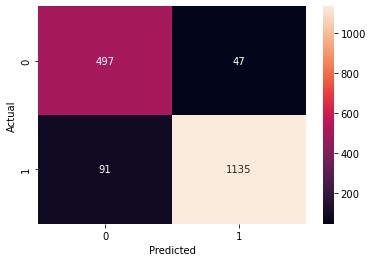

In [43]:
#  Evaluating the Model
nb_scores = cross_val_score(MultinomialNB(), X, y, cv=5)
print('mean_score of cross validation = ', np.mean(nb_scores))
y_pred = nb.predict(X_train)
# plot confusion metrix
confusion = pd.crosstab(y_train, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion, annot=True,fmt='d')

print('Report : \n ', classification_report(y_train, y_pred))
print('Accuracy score  : ' , accuracy_score(y_train, y_pred))

Report : 
                precision    recall  f1-score   support

           0       0.78      0.83      0.81        60
           1       0.92      0.90      0.91       137

    accuracy                           0.88       197
   macro avg       0.85      0.87      0.86       197
weighted avg       0.88      0.88      0.88       197

Accuracy score  :  0.8781725888324873


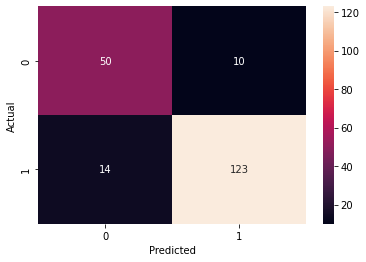

In [44]:
#  Evaluating the Model with test set
y_pred = nb.predict(X_test)

# plot confusion metrix
confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion, annot=True,fmt='d')

print('Report : \n ', classification_report(y_test, y_pred))
print('Accuracy score  : ' , accuracy_score(y_test, y_pred))

#### 5.1 Pull out the log probabilities and convert them to probabilities (for positive and for negative).

In [45]:
feat_lp = nb.feature_log_prob_
feat_lp.shape

(2, 3000)

In [46]:
positive_p = np.exp(feat_lp[1])
positive_p[:5]

array([7.68285187e-05, 3.07314075e-04, 9.98770744e-04, 7.68285187e-05,
       7.68285187e-05])

In [47]:
negative_p = np.exp(feat_lp[0])
negative_p[:5]

array([0.00029652, 0.00014826, 0.00014826, 0.00029652, 0.00029652])

In [48]:
# feat_probs = pd.DataFrame({'pos_p':positive_p, 'neg_p':negative_p, 'feature':words.columns.values})
feat_probs = pd.DataFrame({'pos_p':positive_p, 'neg_p':negative_p, 'feature':z_columns})

In [49]:
feat_probs['positive_diff'] = feat_probs.pos_p - feat_probs.neg_p
feat_probs['positive_diff'] 

0      -0.000220
1       0.000159
2       0.000851
3      -0.000220
4      -0.000220
          ...   
2995    0.000005
2996    0.000005
2997    0.000390
2998   -0.000071
2999   -0.000071
Name: positive_diff, Length: 3000, dtype: float64

In [50]:
# Look at the most likely words for positive news
feat_probs.sort_values('positive_diff', ascending=False, inplace=True) 
feat_probs.head(30)['feature']

946        increase
2142           rise
2297        service
1562            new
42        agreement
2335           sign
1677          order
788            grow
194        business
2405       solution
932         improve
363        customer
2636     technology
112           award
1373         market
2947            win
548          expand
2556         supply
789          growth
1941        project
1219           lead
1660      operation
326        contract
2513         strong
1927        product
1473         mobile
757            good
46              aim
1960        provide
14      acquisition
Name: feature, dtype: object

In [51]:
# Look at the most likely words for negative news
feat_probs.sort_values('positive_diff', ascending=True, inplace=True) #negative
feat_probs.head(30)['feature']

385          decrease
1934           profit
577              fall
1659        operating
1303             loss
285           compare
804              half
1216              lay
2120           result
1985          quarter
1785           period
439              drop
1307              low
366               cut
384           decline
469          employee
1546      negotiation
1792        personnel
2241          scanfil
2456            staff
1043             item
342     corresponding
2377             slip
446             early
2913          warning
2660      temporarily
2042            recur
2661        temporary
542           exclude
1618           number
Name: feature, dtype: object

#### 5.2 Look at the top 10 news and sentiments likely to be positive and top 10 likely to be negative

In [52]:
nbfull = MultinomialNB().fit(X,y)
nbfull.predict_proba(X)

array([[9.99999791e-01, 2.09141044e-07],
       [2.12528946e-05, 9.99978747e-01],
       [4.44877353e-03, 9.95551226e-01],
       ...,
       [8.93732569e-01, 1.06267431e-01],
       [9.98158494e-01, 1.84150643e-03],
       [9.98788031e-01, 1.21196923e-03]])

In [53]:
pp = pd.DataFrame({
        'prob_positive':nbfull.predict_proba(X)[:,1],
        'title' : data['News Headline']
    })

In [54]:
pp.sort_values('prob_positive', ascending=False, inplace=True)
pp

,prob_positive,title
617,1.000000e+00,selects third party logistics leader transplac...
612,1.000000e+00,outotec oyj press release december ...
4080,1.000000e+00,having a china based operation will not only e...
620,1.000000e+00,based on strong customer interest and feedback...
203,1.000000e+00,following the acquisition relacom will stren...
...,...,...
4303,1.043030e-07,after chuck smith was laid off on may from ...
4299,8.722756e-08,november finnish office furniture ma...
3029,4.445807e-08,metso foundries jyvaskyla inc will begin pe...
2756,2.095700e-09,scanfil a systems supplier and contract manu...


In [55]:
# top 10 positive news from prediction of the model
pp.sort_values('prob_positive', ascending=False, inplace=True)
for Sentiments, title in zip(pp.prob_positive[0:10], pp.title[0:10]):
    print(Sentiments, '\t', title)
    print('--------------------------------------------------\n')

0.9999999999106706 	 selects third party logistics leader transplace for best in class technology   procurement capabilities   leading specialty packaging manufacturer employs complete  pl solution for supply chain visibility and transportation efficiency to increase service levels and on time deliveries
--------------------------------------------------

0.9999999987755928 	 outotec oyj press release december                am outotec establishes a new subsidiary in kolkata outotec has established a subsidiary in india in order to better serve its indian customers and to increase its business in the growing indian market  
--------------------------------------------------

0.9999999986495993 	 having a china based operation will not only enable us to fully leverage our resources and expertise in wireless solutions   but also strengthen our capability to offer industry leading products for our customers in china     
--------------------------------------------------

0.99999999847324

In [56]:
# top 10 negative news from prediction of the model
pp.sort_values('prob_positive', ascending=True, inplace=True)
for Sentiments, title in zip(pp.prob_positive[0:10], pp.title[0:10]):
    print(Sentiments, '\t', title)
    print('--------------------------------------------------\n')

8.531030615641317e-10 	 the seawind that was en route from the finnish port of turku to stockholm got stuck in ice already around   p m  on wednesday and the regal star  s journey from the swedish port of kapellskar to paldiski in northwestern estonia was cut short at   a m  on thursday  
--------------------------------------------------

2.095699629776393e-09 	 scanfil   a systems supplier and contract manufacturer to the communications sector   will start personnel negotiations in oulu   in finland   to lay off staff temporarily  
--------------------------------------------------

4.4458072215828154e-08 	 metso foundries jyvaskyla   inc  will begin personnel negotiations on temporary lay offs and personnel reductions in jyvaskyla   finland  
--------------------------------------------------

8.722755611574115e-08 	    november        finnish office furniture maker martela oyj hel   maras said today that it will make redundant three people and other nine will be laid off permanentl

In [57]:
# cross validation for all data 
scores = cross_val_score(nb, X, y, cv = 5, scoring = 'accuracy')
print('Accuracy: %.2f (+/- %.2f)' % (scores.mean(), scores.std()))

Accuracy: 0.78 (+/- 0.06)


### Part 5.2 Build a stacking model

In [58]:
np.random.seed(0)
# list of based-model/learner of stacking model
clf1 = BernoulliNB()
clf2 = RandomForestClassifier()
clf3 = KNeighborsClassifier(n_neighbors=2)
clf4 = LogisticRegression(multi_class = 'auto', solver = 'lbfgs')

# lr = LogisticRegression(multi_class = 'auto', solver = 'lbfgs')
meta = MultinomialNB()
sclf = StackingClassifier(
    classifiers = [clf1, clf2, clf3,clf4],
    meta_classifier = meta)

In [59]:
# accuracy score of cross validation of the model
scores = cross_val_score(sclf, X, y, cv = 5, scoring = 'accuracy')
print('Accuracy: %.2f (+/- %.2f)' % (scores.mean(), scores.std()))

Accuracy: 0.70 (+/- 0.03)


In [60]:
sclf.fit(X_train,y_train)
sclf.predict_proba(X)

array([[0.30734463, 0.69265537],
       [0.02088343, 0.97911657],
       [0.02088343, 0.97911657],
       ...,
       [0.30734463, 0.69265537],
       [0.30734463, 0.69265537],
       [0.30734463, 0.69265537]])

In [61]:
# dataframe of probability of prediction from stacking model
pp_sclf = pd.DataFrame({
        'prob_positive':sclf.predict_proba(X)[:,1],
        'title' : data['News Headline'],
        'label' : data['Sentiment']
    })
pp_sclf.head(10)

,prob_positive,title,label
2,0.692655,the international electronic industry company ...,0
3,0.979117,with the new production plant the company woul...,1
4,0.979117,according to the company s updated strategy f...,1
5,0.979117,financing of aspocomp s growth aspocomp is ag...,1
6,0.870951,for the last quarter of componenta s n...,1
7,0.979117,in the third quarter of net sales incre...,1
8,0.870951,operating profit rose to eur mn from eur ...,1
9,0.979117,operating profit totalled eur mn up fro...,1
10,0.979117,teliasonera tlsn said the offer is in line wit...,1
11,0.979117,stora enso norske skog m real upm kymmen...,1


In [62]:
#top 10 positive news from prediction
pp_sclf.sort_values('prob_positive', ascending=False, inplace=True)
for Sentiment, title in zip(pp_sclf.prob_positive[0:10], pp_sclf.title[0:10]):
    print(Sentiment, '\t', title)
    print('--------------------------------------------------\n')

0.9934599734357483 	 unit costs for flight operations fell by     percent  
--------------------------------------------------

0.9934599734357483 	 ebit totalled eur      mn   compared to a loss of eur     mn in the corresponding period in       
--------------------------------------------------

0.9934599734357483 	 nokia will certainly disagree with qualcomm  s views on the patent situation  
--------------------------------------------------

0.9934599734357483 	 consolidated operating profit excluding one off items was eur      mn   up from eur      mn a year earlier  
--------------------------------------------------

0.9934599734357483 	 the period end cash and cash equivalents totaled eur     m   compared to eur      m in the previous year  
--------------------------------------------------

0.9934599734357483 	 finnish financial group aktia reports operating profit of eur      mn in january september        up from eur      mn in the corresponding period in       
---------

In [63]:
#top 10 negative news from prediction
pp_sclf.sort_values('prob_positive', ascending=True, inplace=True)
for Sentiment, title in zip(pp_sclf.prob_positive[0:30], pp_sclf.title[0:30]):
    print(Sentiment, '\t', title)
    print('--------------------------------------------------\n')

0.4102348007282279 	 also construction expenses have gone up in russia  
--------------------------------------------------

0.4102348007282279 	 operating profit totaled eur     mn   down from eur     mn in the corresponding period in       
--------------------------------------------------

0.4102348007282279 	 finnish insurance company fennia and kesko group are ending their loyal customer cooperation  
--------------------------------------------------

0.4102348007282279 	 profit before taxes was eur     mn   down from eur     mn  
--------------------------------------------------

0.4102348007282279 	 earnings per share   eps   amounted to eur        down from eur       
--------------------------------------------------

0.4102348007282279 	 operating profit totalled eur      mn   down from eur      mn a year earlier  
--------------------------------------------------

0.4102348007282279 	 thanks to the internet   consumers compare products more than previously and finnish co

Report : 
                precision    recall  f1-score   support

           0       0.96      0.15      0.26       544
           1       0.72      1.00      0.84      1226

    accuracy                           0.74      1770
   macro avg       0.84      0.57      0.55      1770
weighted avg       0.80      0.74      0.66      1770

Accuracy score  :  0.7361581920903955


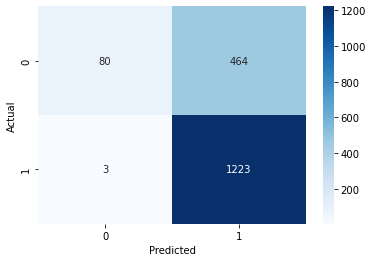

In [64]:
#  Evaluating the Model
y_pred = sclf.predict(X_train)
# plot confusion metrix
confusion = pd.crosstab(y_train, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion, annot=True,fmt='d', cmap = 'Blues')

print('Report : \n ', classification_report(y_train, y_pred))
print('Accuracy score  : ' , accuracy_score(y_train, y_pred))

Report : 
                precision    recall  f1-score   support

           0       0.40      0.03      0.06        60
           1       0.70      0.98      0.81       137

    accuracy                           0.69       197
   macro avg       0.55      0.51      0.44       197
weighted avg       0.61      0.69      0.59       197

Accuracy score  :  0.6903553299492385


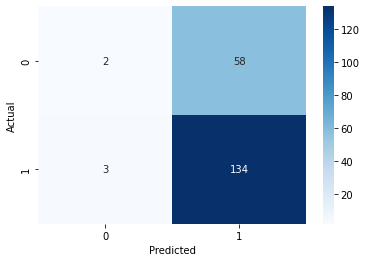

In [65]:
######  Evaluating the Model
y_pred2 = sclf.predict(X_test)

# plot confusion metrix
confusion = pd.crosstab(y_test, y_pred2, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion, annot=True,fmt='d', cmap = 'Blues')

print('Report : \n ', classification_report(y_test, y_pred2))
print('Accuracy score  : ' , accuracy_score(y_test, y_pred2))

### Part 5. Build a Neural Network model

In [66]:
# configure neural network model
model = Sequential()
model.add(Dense(300, input_shape=(X_train.shape[1], ), activation='tanh',name='dense_1'))
model.add(Dense(30, activation='tanh', name='dense_2'))
model.add(Dense(4, activation='tanh', name='dense_3'))
model.add(Dense(1,  activation='sigmoid', name='dense_output'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 300)               900300    
                                                                 
 dense_2 (Dense)             (None, 30)                9030      
                                                                 
 dense_3 (Dense)             (None, 4)                 124       
                                                                 
 dense_output (Dense)        (None, 1)                 5         
                                                                 
Total params: 909,459
Trainable params: 909,459
Non-trainable params: 0
_________________________________________________________________


2022-06-09 10:44:20.637513: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [67]:
from tensorflow import keras
model.compile(optimizer=keras.optimizers.Adam(5e-2),
              loss="binary_crossentropy",
              jit_compile=True,
              metrics="accuracy"
             )


In [68]:
# fitting training set to the model
hist = model.fit(X_train, y_train, batch_size=10, epochs=10, validation_data = (X_test, y_test))

Epoch 1/10


2022-06-09 10:44:21.969158: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x7fd41b4b3e10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-09 10:44:21.969207: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2022-06-09 10:44:22.091374: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:237] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 14/177 [=>............................] - ETA: 0s - loss: 0.6837 - accuracy: 0.6286  

2022-06-09 10:44:23.228864: I tensorflow/compiler/jit/xla_compilation_cache.cc:399] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


177/177 [==============================] - 4s 8ms/step - loss: 0.5703 - accuracy: 0.7356 - val_loss: 0.4465 - val_accuracy: 0.8223
Epoch 2/10
177/177 [==============================] - 1s 8ms/step - loss: 0.4384 - accuracy: 0.8305 - val_loss: 0.4552 - val_accuracy: 0.8325
Epoch 3/10
177/177 [==============================] - 1s 8ms/step - loss: 0.3947 - accuracy: 0.8441 - val_loss: 0.3856 - val_accuracy: 0.8426
Epoch 4/10
177/177 [==============================] - 1s 6ms/step - loss: 0.3542 - accuracy: 0.8605 - val_loss: 0.3725 - val_accuracy: 0.7970
Epoch 5/10
177/177 [==============================] - 1s 6ms/step - loss: 0.3346 - accuracy: 0.8672 - val_loss: 0.3960 - val_accuracy: 0.8477
Epoch 6/10
177/177 [==============================] - 1s 6ms/step - loss: 0.3014 - accuracy: 0.8802 - val_loss: 0.3326 - val_accuracy: 0.8528
Epoch 7/10
177/177 [==============================] - 1s 6ms/step - loss: 0.2924 - accuracy: 0.8887 - val_loss: 0.3863 - val_accuracy: 0.8528
Epoch 8/10
177/17

### Part 6. Visualize and evaluation performance of the model

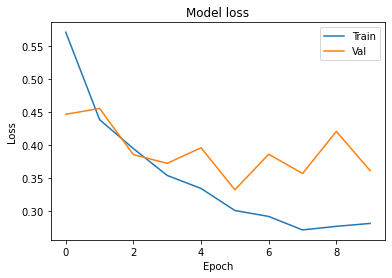

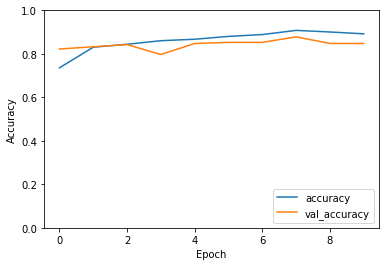

In [69]:
#visualize the training loss and the validation loss to see if the model is overfitting
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.show()

In [70]:
# evaluate the model
model.evaluate(X,y)

62/62 [==============================] - 0s 4ms/step - loss: 0.2851 - accuracy: 0.8785


[0.2850661277770996, 0.8784951567649841]

(1770,)


<AxesSubplot:>

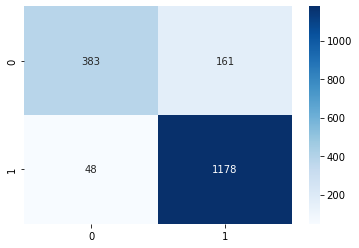

In [86]:
# prediction on train set
# pred = model.predict(X_train)[:,0]
seq_predictions=model.predict(X_train)
# print('Outputs shape')    
# print(seq_predictions.shape) # prints (n,1) but  need (n,)
seq_predictions=np.transpose(seq_predictions)[0]  # transformation to get (n,)
print(seq_predictions.shape)  # now the shape is (n,)
# Applying transformation to get binary values predictions with 0.5 as thresold
seq_predictions = list(map(lambda x: 0 if x<0.5 else 1, seq_predictions))

# plot confusion metrix
# confusion metrix
confusion = tf.math.confusion_matrix(y_train, seq_predictions)
sns.heatmap(confusion, annot=True,fmt='d', cmap = 'Blues')

In [87]:
precise = tf.keras.metrics.PrecisionAtRecall(0.5)
precise.update_state(y_train, seq_predictions)
print('precision of predicting positive news is %.2f' % precise.result().numpy())

precision of predicting positive news is 0.88
sentence   sale finland decrease international sale decrease term euro term local currency
Outputs shape
sentence   February Elcoteq group sell st petersburg facility accord unconfirmed information reason supply problem Russian custom service
Outputs shape
sentence   February Elcoteq group sell st petersburg facility accord unconfirmed information reason supply problem Russian custom service
Outputs shape
sentence   ` ` operate profit decline mainly increase cost wood recycled fiber strengthened euro
Outputs shape
sentence   operate profit decline mainly increase cost wood recycled fiber strengthened euro
Outputs shape
sentence   upm kymmene corp. world large maker magazine paper Tuesday report percent profit drop low paper price high cost strong euro hurt revenue
Outputs shape
sentence   upm kymmene corp. world large maker magazine paper Tuesday report percent profit drop low paper price high cost strong euro hurt revenue
Outputs shape
sen

(197,)


<AxesSubplot:>

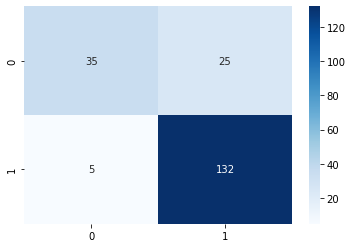

In [83]:
# prediction on test set
# pred = model.predict(X_test)[:,0]

seq_predictions=model.predict(X_test)
# print('Outputs shape')    
# print(seq_predictions.shape) # prints (n,1) but  need (n,)
seq_predictions=np.transpose(seq_predictions)[0]  # transformation to get (n,)
print(seq_predictions.shape)  # now the shape is (n,)
# Applying transformation to get binary values predictions with 0.5 as thresold
seq_predictions = list(map(lambda x: 0 if x<0.5 else 1, seq_predictions))

# confusion metrix
# confusion metrix
confusion = tf.math.confusion_matrix(y_test, seq_predictions)
sns.heatmap(confusion, annot=True,fmt='d', cmap = 'Blues')

In [85]:
# testing set
precise = tf.keras.metrics.PrecisionAtRecall(0.5)
precise.update_state(y_test, seq_predictions)
print('precision of predicting positive news is %.2f' % precise.result().numpy())

precision of predicting positive news is 0.84


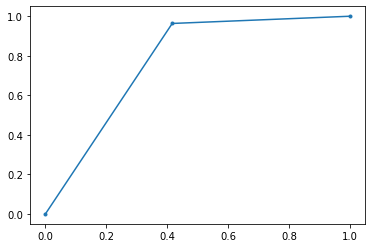

In [74]:
# visualize ROC 
nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, seq_predictions)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)


In [75]:
# create a dataframe of probability of prediction from stacking model
pp_nn = pd.DataFrame({
        'prob_positive':model.predict(X)[:,0],
        'label' : data['Sentiment'],
        'title' : data['News Headline'],
        
    })
pp_nn.tail(10).values

array([[0.6207531094551086, 0,
        'in the baltic states the company reports net sales of eur      mn   down from eur      mn   and an operative ebit of eur      mn   down from eur      mn  '],
       [0.3112460672855377, 0,
        'operating profits in the half were      m   down from      m as glisten invested in the brand and the management team  '],
       [0.055012643337249756, 0,
        'sales in finland decreased by         and international sales decreased by       in terms of euros   and by        in terms of local currencies  '],
       [0.09690225124359131, 0,
        'the company said that its comparable operating profit for the january june period fell short of last year  s corresponding performance  '],
       [0.06549641489982605, 0,
        'operating result for the    month period decreased from the profit of eur     m while turnover decreased from eur     m   as compared to       '],
       [0.029295027256011963, 0,
        'helsinki thomson financial   shares i

In [76]:
#filter news context with negative sentiments
pp_nn[pp_nn['label']==0].values

array([[0.11898323893547058, 0,
        'the international electronic industry company elcoteq has laid off tens of employees from its tallinn facility   contrary to earlier layoffs the company contracted the ranks of its office workers   the daily postimees reported  '],
       [0.029295027256011963, 0,
        'a tinyurl link takes users to a scamming site promising that users can earn thousands of dollars by becoming a google   nasdaq   goog   cash advertiser  '],
       [0.9710583686828613, 0,
        'compared with the ftse     index   which rose      points   or         on the day   this was a relative price change of         '],
       ...,
       [0.6207531094551086, 0,
        'operating profit fell to eur      mn from eur      mn in        including vessel sales gain of eur      mn  '],
       [0.6207531094551086, 0,
        'net sales of the paper segment decreased to eur       mn in the second quarter of      from eur       mn in the second quarter of        while operating

### Part 7. Deployment with Gradio

In [77]:
def inference(text):
    #-----------------
#     text = text.str.lower()
    re.sub("[^a-zA-Z]"," ",text)
    # apply the clean text function into text
    news = convert_text(text)
    
    # create word/token sentence 
    
    tokens = nltk.word_tokenize(news)
    tokens_no_stop = [word for word in tokens if not word in stopWords]
    
    for row,t in enumerate(tokens_no_stop):
        for i in enumerate(tokens_no_stop[row]):
            result = (' '.join(str(x) for x in tokens_no_stop[row]))
    # the news without stopwords
    news_clean = []
    for count, value in enumerate(tokens_no_stop):
        news_clean = ' '.join(tokens_no_stop)
    print('sentence  ', news_clean)
    
    # convert str to list without split text
    news_sent = []
    news_sent.append(news_clean)
    
    # Count Vectorizer
    words_news = cv.transform(news_sent)
    test_cv = pd.DataFrame(words_news.toarray(), columns=cv.get_feature_names_out())
    
    #model prediction
    seq_predictions=model.predict(test_cv)
    print('Outputs shape')    
#     print(seq_predictions.shape) # prints (n,1) but  need (n,)
    seq_predictions=np.transpose(seq_predictions)[0]  # transformation to get (n,)
#     print(seq_predictions.shape)  # now the shape is (n,)

    # Applying transformation to get binary values predictions with 0.5 as thresold
    seq_predictions = list(map(lambda x: 0 if x<0.5 else 1, seq_predictions))
    res = 'Positive Sentiment'if seq_predictions[0] == 1 else 'Negative Sentiment'
   
    return res
    #-----------------
    
text = gr.inputs.Textbox(placeholder="What is your news headline?", lines=3)

gr.Interface(inference, 
             inputs=[text],  
             outputs=gr.outputs.Label(), 
             live=False).launch(share=True) #, debug=True Use in Colab


Running on local URL:  http://127.0.0.1:7860/
Running on public URL: https://34347.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7fd438194760>,
 'http://127.0.0.1:7860/',
 'https://34347.gradio.app')